In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import idx2numpy
import cv2 as cv
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#Loading Data
train_images = "/home/abhineet/Documents/Quantiphi/Training/Assignments/Assignment5/train-images-idx3-ubyte"
train_labels  = "/home/abhineet/Documents/Quantiphi/Training/Assignments/Assignment5/train-labels-idx1-ubyte"
test_images = "/home/abhineet/Documents/Quantiphi/Training/Assignments/Assignment5/t10k-images-idx3-ubyte"
test_labels  = "/home/abhineet/Documents/Quantiphi/Training/Assignments/Assignment5/t10k-labels-idx1-ubyte"


X_train = idx2numpy.convert_from_file(train_images)
y_train = idx2numpy.convert_from_file(train_labels)
X_test = idx2numpy.convert_from_file(test_images)
y_test = idx2numpy.convert_from_file(test_labels)

print(np.shape(X_train))

(60000, 28, 28)


In [11]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

nR = 28
nC = 28
classes = 10
#Model
epochs = 40
b = 128

IS_LOCAL = False

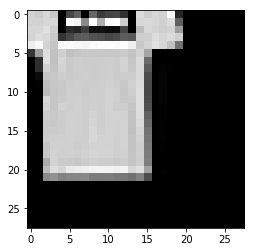

In [4]:
#Data Transformation and Augmentation

T1 = np.float32([[1,0,-6],[0,1,-6]])
trans1 = np.zeros((500,28,28))
for i in range(500):
    trans1[i] = cv.warpAffine(X_train[i],T1,(28,28))
plt.imshow(trans1[1],cmap='gray')

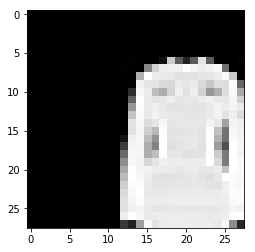

In [5]:
T2 = np.float32([[1,0,6],[0,1,6]])
trans2 = np.zeros((500,28,28))
for i in range(500):
    trans2[i] = cv.warpAffine(X_train[500+i],T2,(28,28))
plt.imshow(trans2[0],cmap='gray')

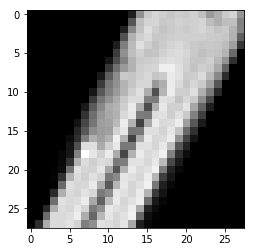

In [6]:
rot1 = np.zeros((500,28,28))
for i in range(500):
    theta = np.random.randint(-60,60)
    R1 = cv.getRotationMatrix2D((14,14),theta,1.5)
    rot1[i] = cv.warpAffine(X_train[1000+i],R1,(28,28))
plt.imshow(rot1[0],cmap='gray')

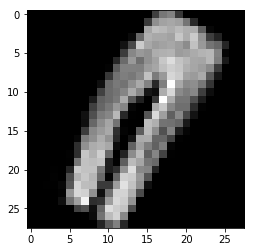

In [7]:
rot2 = np.zeros((500,28,28))
for i in range(500):
    theta = np.random.randint(-30,30)
    R2 = cv.getRotationMatrix2D((14,14),theta,1.0)
    rot2[i] = cv.warpAffine(X_train[1500+i],R2,(28,28))
plt.imshow(rot2[0],cmap='gray')

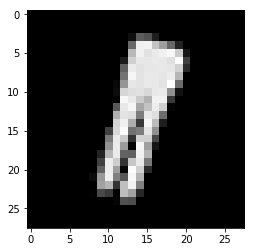

In [8]:
rot3 = np.zeros((500,28,28))
for i in range(500):
    theta = np.random.randint(-45,45)
    R3 = cv.getRotationMatrix2D((14,14),theta, 0.75)
    rot3[i] = cv.warpAffine(X_train[2000+i],R3,(28,28))
plt.imshow(rot3[31],cmap='gray')

In [9]:
X_train = np.concatenate((X_train, trans1, trans2, rot1,rot2,rot3),axis=0)
y_train= np.concatenate((y_train, y_train[0:500],y_train[500:1000],y_train[1000:1500],y_train[1500:2000],y_train[2000:2500]),axis=0)

In [10]:
#Data Preprocessing           
def X_preprocessing(raw):
    num_images = raw.shape[0]
    x_shaped_array = raw.reshape(num_images, nR, nC, 1)
    out_x = x_shaped_array / 255
    return out_x

def y_preprocessing(raw):
    out_y = keras.utils.to_categorical(raw, classes)
    return out_y

X_train = X_preprocessing(X_train)
y_train = y_preprocessing(y_train)
X_test = X_preprocessing(X_test)
y_test = y_preprocessing(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state= 5)

In [12]:
#Keras Model        
def Model(X,Y,x,y, X_test, y_test):
    model = Sequential()
    early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False)
    lrdecay = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.0001)
    # Add convolution 2D
    model.add(Conv2D(6, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(nR, nC, 1)))
    #Add Max Pooling wih Stride 2
    model.add(MaxPooling2D((2, 2), strides = (2,2)))
    model.add(Conv2D(16, kernel_size=(3, 3),activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    # Add dropouts to the model
    model.add(Dropout(0.25))
    model.add(Dense(classes, activation='softmax'))
    model.summary()
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    model.fit(X, Y,
              batch_size=b,
              epochs=epochs,
              verbose=1,
              validation_data=(x, y), callbacks = [lrdecay, early])
    
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    return

with tf.Session() as sess:
    op = Model(X_train, y_train, X_val, y_val, X_test, y_test)
    sess.run(op)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)    

TypeError: Fetch argument None has invalid type <class 'NoneType'>